In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

# Exploring and Cleaning PurpleAir Sensor Data

In [2]:
!ls data/purpleair_AMTS

AMTS_TESTING (outside) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv
AMTS_TESTING (outside) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv
AMTS_TESTING B (undefined) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv
AMTS_TESTING B (undefined) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv


In [3]:
pa_csvs = !ls data/purpleair_AMTS
pa_csvs

['AMTS_TESTING (outside) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv',
 'AMTS_TESTING (outside) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv',
 'AMTS_TESTING B (undefined) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv',
 'AMTS_TESTING B (undefined) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv']

In [4]:
pa = pd.read_csv(f'data/purpleair_AMTS/{pa_csvs[0]}')
pa

,created_at,entry_id,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,...,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3,Unnamed: 10
0,2018-05-20 00:00:35 UTC,20733,0.98,1.23,...,83.0,32.0,1.23,NaN
1,2018-05-20 00:01:55 UTC,20734,0.96,1.94,...,83.0,32.0,1.94,NaN
2,2018-05-20 00:03:15 UTC,20735,1.07,1.80,...,83.0,32.0,1.80,NaN
...,...,...,...,...,...,...,...,...,...
672752,2019-12-29 23:55:30 UTC,523358,24.44,40.45,...,52.0,67.0,36.91,NaN
672753,2019-12-29 23:57:30 UTC,523359,23.69,37.72,...,58.0,67.0,35.49,NaN
672754,2019-12-29 23:59:30 UTC,523360,24.60,37.57,...,58.0,66.0,35.33,NaN


In [5]:
display_df(pa.iloc[0].to_frame().reset_index(), rows=11)

,index,0
0,created_at,2018-05-20 00:00:35 UTC
1,entry_id,20733
2,PM1.0_CF1_ug/m3,0.98
3,PM2.5_CF1_ug/m3,1.23
4,PM10.0_CF1_ug/m3,1.23
5,UptimeMinutes,2299.0
6,RSSI_dbm,-62.0
7,Temperature_F,83.0
8,Humidity_%,32.0
9,PM2.5_ATM_ug/m3,1.23


Data dictionary: https://docs.google.com/document/d/15ijz94dXJ-YAZLi9iZ_RaBwrZ4KtYeCy08goGBwnbCU/edit (from https://www.purpleair.com/sensorlist)

Important columns are created_at, PM2.5_CF1_ug/m3, temp, RH

questions:

1. what columns do we want to keep?
1. what's the difference between PM2.5_CF1 and PM2.5_ATM?
1. what's granularity of data?
1. when we aggregate, what do we do about missing data?
1. what if sensor A and B disagree?

## What columns do we want to keep?

In [6]:
def subset_cols(pa):
    cols = [
        'created_at', 'PM2.5_CF1_ug/m3', 'Temperature_F', 'Humidity_%',
        'PM2.5_ATM_ug/m3'
    ]
    return (pa[cols].rename(
        columns={
            'PM2.5_CF1_ug/m3': 'PM25cf1',
            'Temperature_F': 'TempF',
            'Humidity_%': 'RH',
            'PM2.5_ATM_ug/m3': 'PM25cfatm'
        }))


In [7]:


pa = (pd.read_csv(f'data/purpleair_AMTS/{pa_csvs[0]}')
      .pipe(subset_cols))
pa

,created_at,PM25cf1,TempF,RH,PM25cfatm
0,2018-05-20 00:00:35 UTC,1.23,83.0,32.0,1.23
1,2018-05-20 00:01:55 UTC,1.94,83.0,32.0,1.94
2,2018-05-20 00:03:15 UTC,1.80,83.0,32.0,1.80
...,...,...,...,...,...
672752,2019-12-29 23:55:30 UTC,40.45,52.0,67.0,36.91
672753,2019-12-29 23:57:30 UTC,37.72,58.0,67.0,35.49
672754,2019-12-29 23:59:30 UTC,37.57,58.0,66.0,35.33


## What's the difference between CF1 and ATM?

<AxesSubplot:xlabel='PM25cf1', ylabel='Density'>

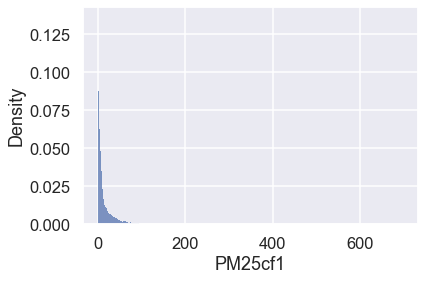

In [8]:
sns.histplot(data=pa, x='PM25cf1', stat='density')

<AxesSubplot:xlabel='PM25cfatm', ylabel='Density'>

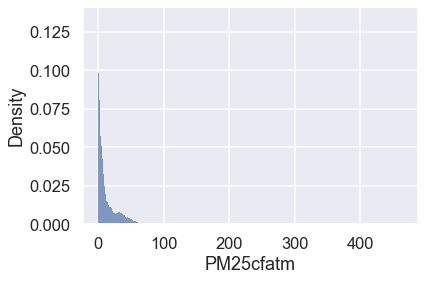

In [9]:
sns.histplot(data=pa, x='PM25cfatm', stat='density')

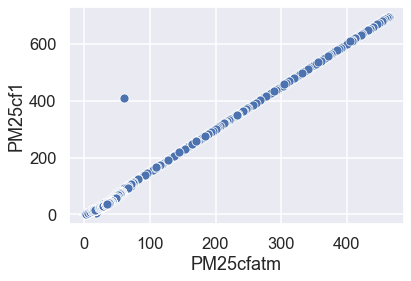

In [10]:
sns.scatterplot(data=pa, x='PM25cfatm', y='PM25cf1');

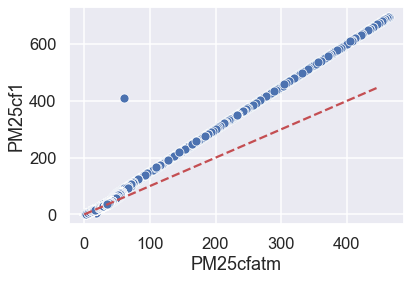

In [11]:
sns.scatterplot(data=pa, x='PM25cfatm', y='PM25cf1')
line = np.arange(0, 450)
plt.plot(line, line, linestyle='--', c='r');

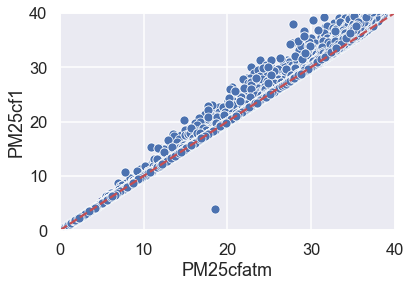

In [12]:
sns.scatterplot(data=pa, x='PM25cfatm', y='PM25cf1')
line = np.arange(0, 450)
plt.plot(line, line, linestyle='--', c='r')
plt.xlim(0, 40)
plt.ylim(0, 40);


so cf1 is generally larger than atm...

In [13]:
pa[pa['PM25cf1'] < pa['PM25cfatm']]

,created_at,PM25cf1,TempF,RH,PM25cfatm
532093,2019-06-29 17:52:18 UTC,4.0,87.0,28.0,18.54


more investigation shows that PA sensors apply a bit of math while processing
the readings. they use two different correction factors; cf1 is more
"conservative" since it's usually higher.

## What's the granularity of the data?

In [14]:
times = pd.to_datetime(pa['created_at'], infer_datetime_format=True)
times

0        2018-05-20 00:00:35+00:00
1        2018-05-20 00:01:55+00:00
2        2018-05-20 00:03:15+00:00
                    ...           
672752   2019-12-29 23:55:30+00:00
672753   2019-12-29 23:57:30+00:00
672754   2019-12-29 23:59:30+00:00
Name: created_at, Length: 672755, dtype: datetime64[ns, UTC]

<AxesSubplot:xlabel='created_at', ylabel='Count'>

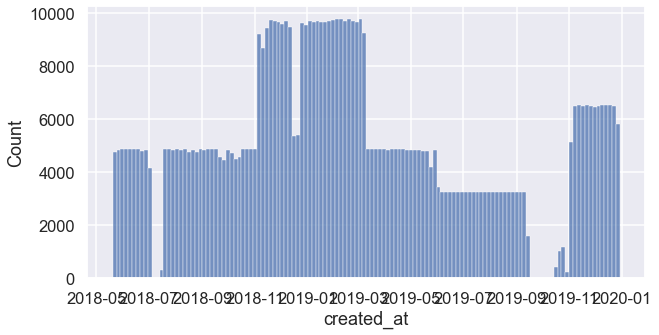

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(times)

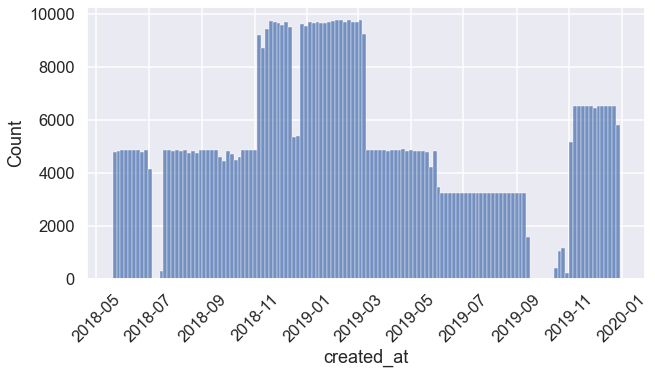

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(times)
plt.xticks(rotation=45);

In [17]:
times.diff()

0                    NaT
1        0 days 00:01:20
2        0 days 00:01:20
               ...      
672752   0 days 00:01:59
672753   0 days 00:02:00
672754   0 days 00:02:00
Name: created_at, Length: 672755, dtype: timedelta64[ns]

In [18]:
intervals = (times.diff()
 .dt.total_seconds()
 .dropna()
)
intervals

1          80.0
2          80.0
3          80.0
          ...  
672752    119.0
672753    120.0
672754    120.0
Name: created_at, Length: 672754, dtype: float64

In [19]:
display_df(intervals.value_counts().head(10), rows=10)

80.0     368953
120.0    120115
81.0      47328
79.0      47142
121.0     13225
119.0     12966
82.0       8960
78.0       8678
77.0       6268
83.0       6134
Name: created_at, dtype: int64

Most readings happen every 80 or 120 seconds.

(making a histogram of `intervals` doesn't complete in a reasonable time by default...)

<AxesSubplot:xlabel='created_at', ylabel='Count'>

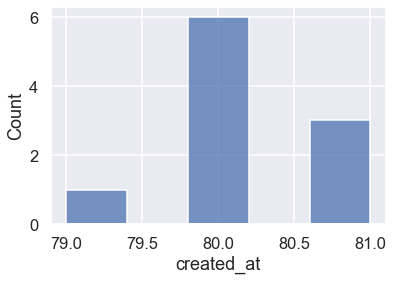

In [20]:
sns.histplot(intervals.sample(10))

<AxesSubplot:xlabel='created_at', ylabel='Count'>

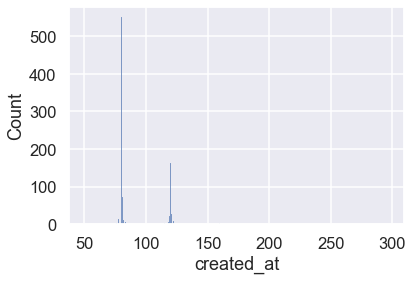

In [21]:
sns.histplot(intervals.sample(1000))

<AxesSubplot:xlabel='created_at', ylabel='Count'>

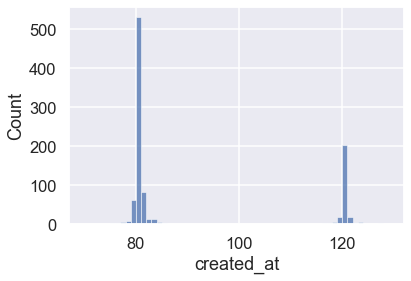

In [22]:
sns.histplot(intervals.sample(1000), bins=np.arange(70, 130))

it turns out that purpleair switched from 80s to 120s intervals on may 30, 2019.

In [23]:
def process_times(pa):
    times = pd.to_datetime(pa['created_at'], infer_datetime_format=True)
    return (pa
        .assign(timestamp=times)
        .drop(columns=['created_at'])
        .set_index('timestamp')
    )

In [24]:
pa = (pd.read_csv(f'data/purpleair_AMTS/{pa_csvs[0]}')
      .pipe(subset_cols)
      .pipe(process_times))
pa

,PM25cf1,TempF,RH,PM25cfatm
timestamp,,,,
2018-05-20 00:00:35+00:00,1.23,83.0,32.0,1.23
2018-05-20 00:01:55+00:00,1.94,83.0,32.0,1.94
2018-05-20 00:03:15+00:00,1.80,83.0,32.0,1.80
...,...,...,...,...
2019-12-29 23:55:30+00:00,40.45,52.0,67.0,36.91
2019-12-29 23:57:30+00:00,37.72,58.0,67.0,35.49
2019-12-29 23:59:30+00:00,37.57,58.0,66.0,35.33


## What do we do about missing data?

we want to average together the measurements within each day. what do we do
about missing data? we say that if the sensor has 90% of the measurements
within a day, we'll keep the average. otherwise, we'll drop it.

but within a day is also tricky because of timestamps...we need to adjust the
timezone to UTC-8 time since these measurements were taken in CA. the AQS
dataset uses the local date, so if we don't adjust for timezone then we won't
average the right data together.

In [25]:
# https://pvlib-python.readthedocs.io/en/stable/timetimezones.html
pa.index.tz_convert('US/Pacific')


DatetimeIndex(['2018-05-19 17:00:35-07:00', '2018-05-19 17:01:55-07:00',
               '2018-05-19 17:03:15-07:00', '2018-05-19 17:04:35-07:00',
               '2018-05-19 17:05:55-07:00', '2018-05-19 17:07:15-07:00',
               '2018-05-19 17:08:35-07:00', '2018-05-19 17:09:55-07:00',
               '2018-05-19 17:11:17-07:00', '2018-05-19 17:12:35-07:00',
               ...
               '2019-12-29 15:41:30-08:00', '2019-12-29 15:43:31-08:00',
               '2019-12-29 15:45:30-08:00', '2019-12-29 15:47:30-08:00',
               '2019-12-29 15:49:30-08:00', '2019-12-29 15:51:30-08:00',
               '2019-12-29 15:53:31-08:00', '2019-12-29 15:55:30-08:00',
               '2019-12-29 15:57:30-08:00', '2019-12-29 15:59:30-08:00'],
              dtype='datetime64[ns, US/Pacific]', name='timestamp', length=672755, freq=None)

In [26]:
def convert_tz(pa):
    pst = pa.index.tz_convert('US/Pacific')
    pa.index = pst
    return pa

In [27]:
pa = (pd.read_csv(f'data/purpleair_AMTS/{pa_csvs[0]}')
      .pipe(subset_cols)
      .pipe(process_times)
      .pipe(convert_tz))
pa

,PM25cf1,TempF,RH,PM25cfatm
timestamp,,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0,1.23
2018-05-19 17:01:55-07:00,1.94,83.0,32.0,1.94
2018-05-19 17:03:15-07:00,1.80,83.0,32.0,1.80
...,...,...,...,...
2019-12-29 15:55:30-08:00,40.45,52.0,67.0,36.91
2019-12-29 15:57:30-08:00,37.72,58.0,67.0,35.49
2019-12-29 15:59:30-08:00,37.57,58.0,66.0,35.33


now, let's count the observations within each day

In [28]:
# resample only works when the index of a dataframe is a datetimeindex
pa.resample('D').size()

timestamp
2018-05-19 00:00:00-07:00     315
2018-05-20 00:00:00-07:00    1079
2018-05-21 00:00:00-07:00    1074
                             ... 
2019-12-27 00:00:00-08:00    1440
2019-12-28 00:00:00-08:00    1200
2019-12-29 00:00:00-08:00     480
Freq: D, Length: 590, dtype: int64

<AxesSubplot:ylabel='Count'>

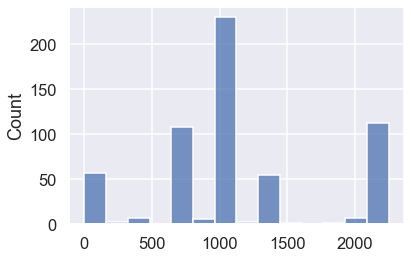

In [29]:
sns.histplot(pa.resample('D').size())

how observations do we expect? for 80s averages, there are 1080 intervals. for
120s, there are 720 intervals. so we'll keep a day's average if there are at
least 90% of those. (remembering that after may 30, 2019, PA switched to 120s
intervals.)

In [30]:
needed_measurements_80s = 0.9 * 1080
needed_measurements_120s = 0.9 * 720
cutoff_date = pd.Timestamp('2019-05-30', tz='US/Pacific')

def has_enough_readings(series):
    if len(series) == 0: return False
    date = series.index[0]
    return (len(series) >= needed_measurements_80s
            if date < cutoff_date
            else len(series) >= needed_measurements_120s)


In [31]:
should_keep = (pa.resample('D')
 ['PM25cf1']
 .agg(has_enough_readings)
 .rename('keep')
)
should_keep

timestamp
2018-05-19 00:00:00-07:00    False
2018-05-20 00:00:00-07:00     True
2018-05-21 00:00:00-07:00     True
                             ...  
2019-12-27 00:00:00-08:00     True
2019-12-28 00:00:00-08:00     True
2019-12-29 00:00:00-08:00    False
Freq: D, Name: keep, Length: 590, dtype: bool

now we can group

In [32]:
(pa.resample('D')
 .mean()
 .loc[should_keep]
 )

,PM25cf1,TempF,RH,PM25cfatm
timestamp,,,,
2018-05-20 00:00:00-07:00,2.48,83.35,28.72,2.48
2018-05-21 00:00:00-07:00,3.00,83.25,29.91,3.00
2018-05-22 00:00:00-07:00,3.47,83.09,31.50,3.47
...,...,...,...,...
2019-12-26 00:00:00-08:00,1.56,54.46,48.93,1.54
2019-12-27 00:00:00-08:00,7.66,54.38,46.43,7.58
2019-12-28 00:00:00-08:00,33.59,53.95,51.26,32.14


finally, we can put this step into the pipeline:

In [33]:
def compute_daily_avgs(pa):
    should_keep = (pa.resample('D')
        ['PM25cf1']
        .agg(has_enough_readings)
        .rename('keep')
    )
    return (pa.resample('D')
        .mean()
        .loc[should_keep]
    )

In [34]:
pa = (pd.read_csv(f'data/purpleair_AMTS/{pa_csvs[0]}')
      .pipe(subset_cols)
      .pipe(process_times)
      .pipe(convert_tz)
      .pipe(compute_daily_avgs))
pa

,PM25cf1,TempF,RH,PM25cfatm
timestamp,,,,
2018-05-20 00:00:00-07:00,2.48,83.35,28.72,2.48
2018-05-21 00:00:00-07:00,3.00,83.25,29.91,3.00
2018-05-22 00:00:00-07:00,3.47,83.09,31.50,3.47
...,...,...,...,...
2019-12-26 00:00:00-08:00,1.56,54.46,48.93,1.54
2019-12-27 00:00:00-08:00,7.66,54.38,46.43,7.58
2019-12-28 00:00:00-08:00,33.59,53.95,51.26,32.14


## What if A and B channels disagree?

PA sensors have two channels. if they disagree, the sensor might be unreliable
so we can drop the data.

we can easily repeat processing on B channel dataset:

In [35]:
pa_csvs

['AMTS_TESTING (outside) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv',
 'AMTS_TESTING (outside) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv',
 'AMTS_TESTING B (undefined) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv',
 'AMTS_TESTING B (undefined) (38.568404 -121.493163) Secondary Real Time 05_20_2018 12_29_2019.csv']

In [36]:
pa_B = pd.read_csv(f'data/purpleair_AMTS/{pa_csvs[2]}')
pa_B

,created_at,entry_id,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,...,Pressure_hpa,IAQ,PM2.5_ATM_ug/m3,Unnamed: 10
0,2018-05-20 00:01:05 UTC,20741,1.44,1.51,...,1010.73,NaN,1.51,NaN
1,2018-05-20 00:02:25 UTC,20742,1.27,1.33,...,1010.75,NaN,1.33,NaN
2,2018-05-20 00:03:45 UTC,20743,1.34,1.83,...,1010.76,NaN,1.83,NaN
...,...,...,...,...,...,...,...,...,...
672479,2019-12-29 23:55:33 UTC,523169,27.84,40.72,...,1016.96,NaN,38.86,NaN
672480,2019-12-29 23:57:33 UTC,523170,27.58,39.42,...,1016.91,NaN,38.14,NaN
672481,2019-12-29 23:59:33 UTC,523171,27.54,39.49,...,1016.93,NaN,38.13,NaN


But the columns of B are different...

In [37]:
pa_B.columns

Index(['created_at', 'entry_id', 'PM1.0_CF1_ug/m3', 'PM2.5_CF1_ug/m3',
       'PM10.0_CF1_ug/m3', 'UptimeMinutes', 'ADC', 'Pressure_hpa', 'IAQ',
       'PM2.5_ATM_ug/m3', 'Unnamed: 10'],
      dtype='object')

we can define the subsetting step:

In [38]:
def subset_cols_B(pa):
    cols = [
        'created_at', 'PM2.5_CF1_ug/m3', 'PM2.5_ATM_ug/m3'
    ]
    return (pa[cols].rename(
        columns={
            'PM2.5_CF1_ug/m3': 'PM25cf1',
            'PM2.5_ATM_ug/m3': 'PM25cfatm'
        }))


Then reuse pipeline

In [39]:
pa_B = (pd.read_csv(f'data/purpleair_AMTS/{pa_csvs[2]}')
      .pipe(subset_cols_B)
      .pipe(process_times)
      .pipe(convert_tz)
      .pipe(compute_daily_avgs)
      )
pa_B

,PM25cf1,PM25cfatm
timestamp,,
2018-05-20 00:00:00-07:00,2.42,2.42
2018-05-21 00:00:00-07:00,3.01,3.01
2018-05-22 00:00:00-07:00,3.46,3.46
...,...,...
2019-12-26 00:00:00-08:00,1.42,1.40
2019-12-27 00:00:00-08:00,8.08,8.01
2019-12-28 00:00:00-08:00,36.78,35.22


In [40]:
pa

,PM25cf1,TempF,RH,PM25cfatm
timestamp,,,,
2018-05-20 00:00:00-07:00,2.48,83.35,28.72,2.48
2018-05-21 00:00:00-07:00,3.00,83.25,29.91,3.00
2018-05-22 00:00:00-07:00,3.47,83.09,31.50,3.47
...,...,...,...,...
2019-12-26 00:00:00-08:00,1.56,54.46,48.93,1.54
2019-12-27 00:00:00-08:00,7.66,54.38,46.43,7.58
2019-12-28 00:00:00-08:00,33.59,53.95,51.26,32.14


we see some differences. again, apply threshold. if A and B differ by more than
61% or by 5 ug/m3, remove day.

In [41]:
A = pa['PM25cf1']
B = pa_B['PM25cf1']

abs_diff = (A - B).abs()
perc_diff = (A - B) * 2 / (A + B)
should_drop = (perc_diff >= 0.61) | (abs_diff >= 5)
np.count_nonzero(should_drop)

13

In [42]:
def average_A_B(pa):
    avg_cf1 = (pa['PM25cf1'] + pa_B['PM25cf1']) / 2
    avg_atm = (pa['PM25cfatm'] + pa_B['PM25cfatm']) / 2
    return pa.assign(avg_cf1=avg_cf1, avg_atm=avg_atm)

def drop_when_A_B_disagree(pa):
    A = pa['PM25cf1']
    B = pa_B['PM25cf1']

    abs_diff = (A - B).abs()
    perc_diff = (A - B) * 2 / (A + B)
    should_drop = (perc_diff >= 0.61) | (abs_diff >= 5)
    return pa[~should_drop]

def reassign_avg_to_pm(pa):
    return (pa.drop(columns=['PM25cf1', 'PM25cfatm'])
            .rename(columns={'avg_cf1': 'PM25cf1', 'avg_atm': 'PM25cfatm'})
            [['PM25cf1', 'TempF', 'RH', 'PM25cfatm']]
            )

In [43]:
ca1 = (pa.pipe(average_A_B)
 .pipe(drop_when_A_B_disagree)
 .pipe(reassign_avg_to_pm)
)
ca1

,PM25cf1,TempF,RH,PM25cfatm
timestamp,,,,
2018-05-20 00:00:00-07:00,2.45,83.35,28.72,2.45
2018-05-21 00:00:00-07:00,3.01,83.25,29.91,3.01
2018-05-22 00:00:00-07:00,3.46,83.09,31.50,3.46
...,...,...,...,...
2019-12-26 00:00:00-08:00,1.49,54.46,48.93,1.47
2019-12-27 00:00:00-08:00,7.87,54.38,46.43,7.79
2019-12-28 00:00:00-08:00,35.19,53.95,51.26,33.68


now, we can merge ca1 and the aqs table to get the matched AQS and PA readings.
article did this for 50 sites across the us:

In [3]:
final = pd.read_csv('data/cleaned_purpleair_aqs/Full24hrdataset.csv')
final

,Unnamed: 0,Date,ID,region,...,ratiocfatm_FM,diffcfatm_FM,ratiocf1_FM,diffcf1_FM
0,1,2019-05-17,AK1,Alaska,...,1.23,1.56,1.29,1.92
1,2,2019-05-18,AK1,Alaska,...,0.88,-0.44,0.92,-0.31
2,3,2019-05-21,AK1,Alaska,...,0.95,-0.20,0.95,-0.20
...,...,...,...,...,...,...,...,...,...
12427,12428,2019-02-20,WI6,North,...,1.60,9.41,1.62,9.70
12428,12429,2019-03-04,WI6,North,...,0.59,-5.79,0.59,-5.79
12429,12430,2019-03-22,WI6,North,...,1.63,3.64,1.63,3.64


In [6]:
display_df(final.iloc[0].to_frame(), rows=31)

,0
Unnamed: 0,1
Date,2019-05-17
ID,AK1
region,Alaska
FEMorFRM,FRM
FEMorFRMtype,R & P Model 2025 PM-2.5 Sequential Air Sampler...
PM25FM,6.7
PM25cfatm,8.26
PM25cf1,8.62
b0.3um,1154.62
